<a href="https://colab.research.google.com/github/shahidulislamkhokon/Machine-Learning/blob/main/Satelite_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip -q install torchsummary

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchsummary import summary
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from pathlib import Path
from torch.autograd import Variable
from PIL import Image


# set background color to white
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# set default figure size
matplotlib.rcParams['figure.figsize'] = (15, 7)

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

Data Directory

In [ ]:
DATA_DIR = r'/content/drive/MyDrive/Colab Notebooks/rgb'
pred_path='/content/drive/MyDrive/Colab Notebooks/pred_1'
pred_path='/content/drive/MyDrive/Colab Notebooks/pred_2'
pred_path='/content/drive/MyDrive/Colab Notebooks/pred_3'
pred_path='/content/drive/MyDrive/Colab Notebooks/pred_4'

In [ ]:
#Get filepaths and labels
image_dir = Path(DATA_DIR)
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# remove GT from some label names
image_df['Label'] = image_df['Label'].apply(lambda x: x.replace(" GT", ""))

In [ ]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/Colab Notebooks/rgb/Clo...,Cloudsat
1,/content/drive/MyDrive/Colab Notebooks/rgb/Clo...,Cloudsat
2,/content/drive/MyDrive/Colab Notebooks/rgb/Clo...,Cloudsat
3,/content/drive/MyDrive/Colab Notebooks/rgb/Clo...,Cloudsat
4,/content/drive/MyDrive/Colab Notebooks/rgb/Clo...,Cloudsat
...,...,...
29995,/content/drive/MyDrive/Colab Notebooks/rgb/Acr...,AcrimSat
29996,/content/drive/MyDrive/Colab Notebooks/rgb/Acr...,AcrimSat
29997,/content/drive/MyDrive/Colab Notebooks/rgb/Acr...,AcrimSat
29998,/content/drive/MyDrive/Colab Notebooks/rgb/Acr...,AcrimSat


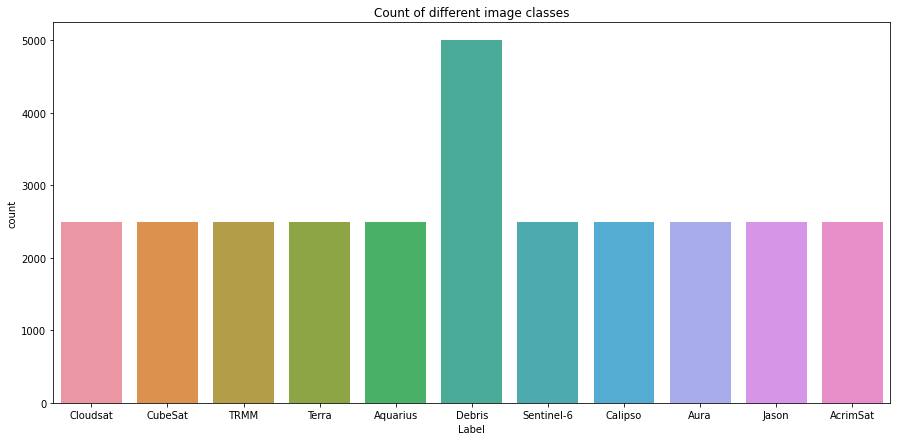

In [ ]:
# count plot for each class
sns.countplot(x='Label', data=image_df).set(title='Count of different image classes')
plt.show()

In [ ]:
# augument and transforms

#Transforms
trans=transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
])                         

images = ImageFolder(root=DATA_DIR, transform=trans)

In [ ]:
# split data to train, test
size = len(images)
test_size = int(0.2 * size)
train_size = int(size - test_size)
print(f"number of classes: {len(images.classes)}")
print(f"total number of images: {size}")
print(f"total number of train images: {train_size}")
print(f"total number of test images: {test_size}")

# random_split
train_set, test_set = random_split(images, (train_size, test_size))

number of classes: 11
total number of images: 30000
total number of train images: 24000
total number of test images: 6000


In [ ]:
num_classes = 11

In [ ]:
# show a single image
def show_image(img, label, dataset):
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.title(dataset.classes[label])

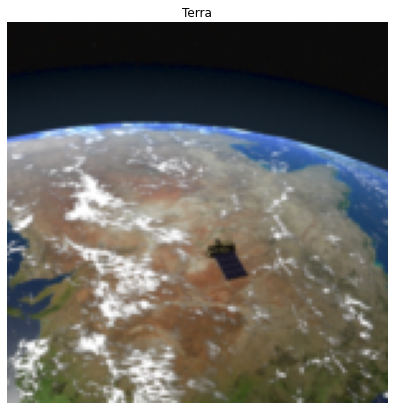

In [ ]:
show_image(*train_set[7], train_set.dataset)

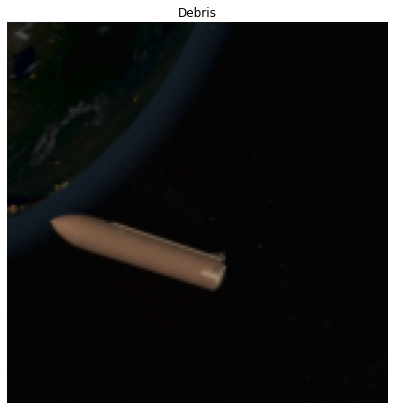

In [ ]:
show_image(*train_set[10], train_set.dataset)

In [ ]:
# create data loaders
batch_size = 64 # larger numbers lead to CUDA running out of memory
train_dl = DataLoader(train_set, batch_size=batch_size)
test_dl = DataLoader(test_set, batch_size=batch_size)
train_count = len(train_dl)
test_count = len(test_dl)

In [ ]:
# visualize a batch of images
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(20, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

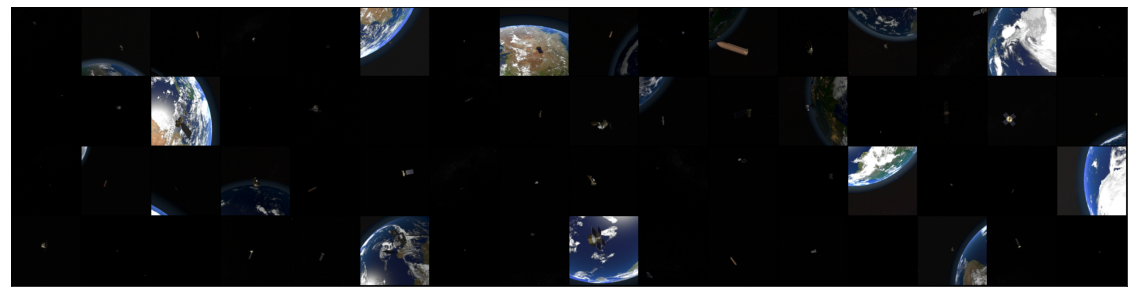

In [ ]:
show_batch(train_dl)

In [ ]:
# convlutional block with batchnorm and max pooling
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [ ]:
# CNN with residual connections
class SateliteResNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512 * 4 * 4, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out # add residual
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out # add residual
        out = self.classifier(out)
        return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # choose device accordingly

model = SateliteResNet(3, 11).to(device) # 3 color channels and 11 output classes
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

# model summary (helps in understanding the output shapes)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
       BatchNorm2d-5        [-1, 128, 128, 128]             256
              ReLU-6        [-1, 128, 128, 128]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [ ]:
# multiclass accuracy
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

In [ ]:
# training loop
epochs = 10
losses = []
for epoch in range(epochs):
    # for custom progress bar
    with tqdm(train_dl, unit="batch") as tepoch:
        epoch_loss = 0
        for data, target in tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}")
            data, target = data.to(device), target.to(device) # move input to GPU
            out = model(data)
            loss = criterion(out, target)
            acc = multi_acc(out, target)
            epoch_loss += loss.item()
            loss.backward()
            optim.step()
            optim.zero_grad()
            tepoch.set_postfix(loss = loss.item(), accuracy = acc.item()) # show loss and accuracy per batch of data
    losses.append(epoch_loss)

Epoch 10: 100%|██████████| 375/375 [13:23<00:00,  2.14s/batch, accuracy=89, loss=0.346]


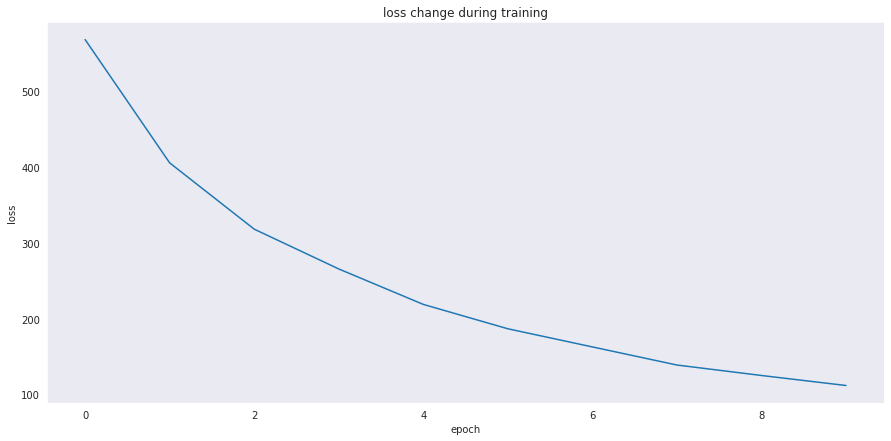

In [ ]:
# plot losses
sns.set_style("dark")
sns.lineplot(data=losses).set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.show()

In [ ]:
# predict on testing data samples (the accuracy here is batch accuracy)
y_pred_list = []
y_true_list = []
with torch.no_grad():
    with tqdm(test_dl, unit="batch") as tepoch:
        for inp, labels in tepoch:
            inp, labels = inp.to(device), labels.to(device)
            y_test_pred = model(inp)
            acc = multi_acc(y_test_pred, labels)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            tepoch.set_postfix(accuracy = acc.item())
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(labels.cpu().numpy())

100%|██████████| 94/94 [37:33<00:00, 23.97s/batch, accuracy=79]


In [ ]:
# flatten prediction and true lists
flat_pred = []
flat_true = []
for i in range(len(y_pred_list)):
    for j in range(len(y_pred_list[i])):
        flat_pred.append(y_pred_list[i][j])
        flat_true.append(y_true_list[i][j])
        
print(f"number of testing samples results: {len(flat_pred)}")

number of testing samples results: 0


In [ ]:
# calculate total testing accuracy
print(f"Testing accuracy is: {accuracy_score(flat_true, flat_pred) * 100:.2f}%")

Testing accuracy is: 87.10%


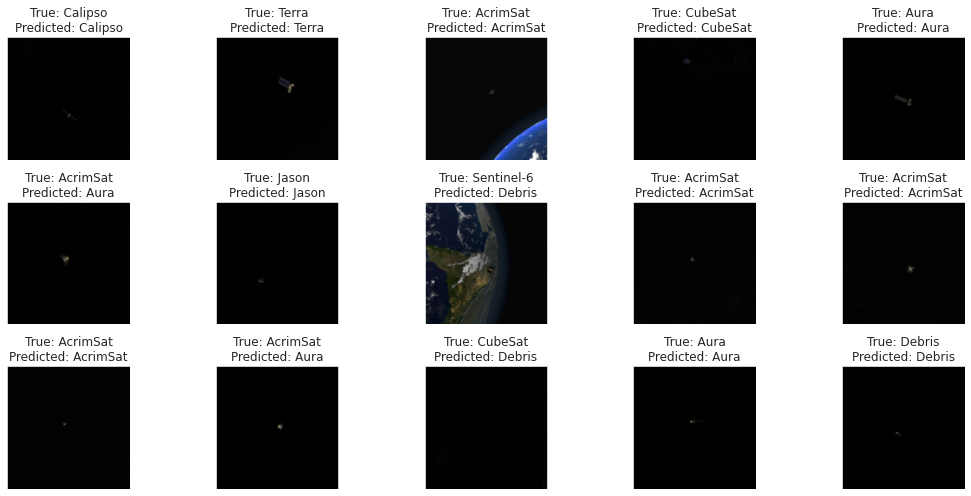

In [ ]:
# Display 15 random picture of the dataset with their labels
inds = np.random.randint(len(test_set), size=15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in zip(inds, axes.flat):
    img, label = test_set[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"True: {test_set.dataset.classes[label]}\nPredicted: {test_set.dataset.classes[flat_pred[i]]}")
plt.tight_layout()
plt.show()

In [ ]:
# classification report
print(classification_report(flat_true, flat_pred, target_names=images.classes))

              precision    recall  f1-score   support

    AcrimSat       0.97      0.90      0.93       535
    Aquarius       0.94      0.74      0.83       459
        Aura       0.75      0.96      0.84       501
     Calipso       0.83      0.93      0.87       483
    Cloudsat       0.93      0.75      0.83       465
     CubeSat       0.94      0.94      0.94       501
      Debris       0.89      0.95      0.92      1022
       Jason       0.88      0.78      0.82       520
  Sentinel-6       0.86      0.93      0.90       525
        TRMM       0.86      0.90      0.88       486
       Terra       0.78      0.71      0.74       503

    accuracy                           0.87      6000
   macro avg       0.87      0.86      0.86      6000
weighted avg       0.88      0.87      0.87      6000



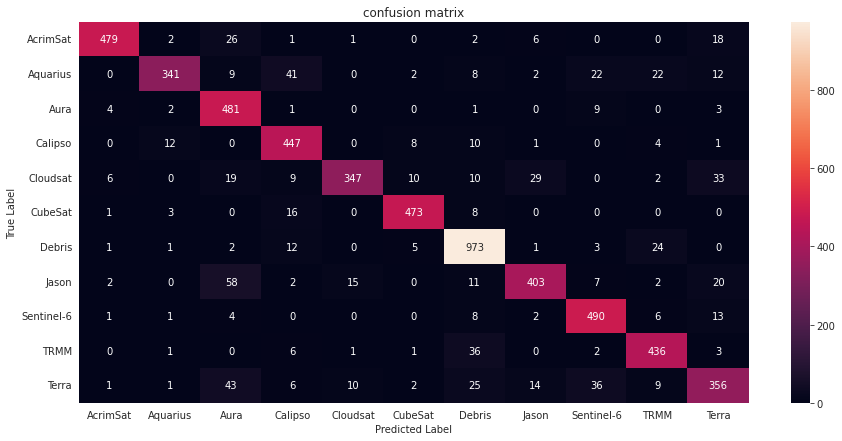

In [ ]:
# plot confusion matrix
idx2class = {v: k for k, v in images.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(flat_true, flat_pred)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True, fmt='').set(title="confusion matrix", xlabel="Predicted Label", ylabel="True Label")
plt.show()

In [ ]:
classes = ["AcrimSat", "Aquarius", "Aquarius", "Calipso", "Cloudsat", "CubeSat", "Debris", "Jason", "Sentinel-6", "Terra", "TRMM"]

In [ ]:
#prediction function
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

def prediction(img_path,transformer):
    image=Image.open(img_path)
    
    image_tensor=transformer(image).float()
    
    
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor=image_tensor.to(device)
        
    input=Variable(image_tensor)
    
    
    output=model(input)
    
    index=output.data.cpu().numpy().argmax()
    
    pred=classes[index]
    
    return pred

In [ ]:
import glob
images_path=glob.glob(pred_path+'/*.png')

In [ ]:
pred_dict={}

for i in images_path:
    pred_dict[i[i.rfind('/')+1:]]=prediction(i,trans)

In [ ]:
pred_dict

{'image_03010_img.png': 'CubeSat',
 'image_03013_img.png': 'AcrimSat',
 'image_03012_img.png': 'Jason',
 'image_03020_img.png': 'Terra',
 'image_03019_img.png': 'AcrimSat',
 'image_03016_img.png': 'AcrimSat',
 'image_03014_img.png': 'CubeSat',
 'image_03015_img.png': 'Jason',
 'image_03022_img.png': 'Terra',
 'image_03023_img.png': 'AcrimSat',
 'image_03024_img.png': 'AcrimSat',
 'image_03025_img.png': 'Calipso',
 'image_03032_img.png': 'AcrimSat',
 'image_03018_img.png': 'AcrimSat',
 'image_03021_img.png': 'AcrimSat',
 'image_03030_img.png': 'Jason',
 'image_03034_img.png': 'AcrimSat',
 'image_03026_img.png': 'AcrimSat',
 'image_03028_img.png': 'AcrimSat',
 'image_03033_img.png': 'AcrimSat',
 'image_03027_img.png': 'Aquarius',
 'image_03037_img.png': 'AcrimSat',
 'image_03035_img.png': 'CubeSat',
 'image_03031_img.png': 'Sentinel-6',
 'image_03029_img.png': 'Terra',
 'image_03040_img.png': 'CubeSat',
 'image_03041_img.png': 'AcrimSat',
 'image_03042_img.png': 'Jason',
 'image_03043_im

In [ ]:
#saving prediction results into csv file

import csv
with open('result.csv', 'w', newline='') as csvfile:
    header_key = ['image', 'class']
    new_val = csv.DictWriter(csvfile, fieldnames=header_key)

    new_val.writeheader()
    for new_k in pred_dict:
        new_val.writerow({'image': new_k, 'class': pred_dict[new_k]})

In [ ]:
with open("result.csv", 'r') as input, open('result_id.csv', 'w') as output:
    reader = csv.reader(input, delimiter = ',')
    writer = csv.writer(output, delimiter = ',')

    all = []
    row = next(reader)
    row.insert(0, 'id  ')
    all.append(row)
    for k, row in enumerate(reader):
        all.append([str(k+11117)] + row)
    writer.writerows(all)